# Bayesian Vector Autoregressive Models in Numpyro

In this notebook, we present how to implement and fit Bayesian Vector Autoregressive (VAR) models using [NumPyro](https://num.pyro.ai/en/stable/). After fitting the model, we compute the Impulse Response Functions (IRFs) and compare the results with the ones obtained using the statsmodels implementation.

https://www.statsmodels.org/stable/vector_ar.html

## Prepare Notebook


In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import statsmodels.api as sm
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Load Data

We are going to use a dataset from the [`statsmodels` package](https://www.statsmodels.org/stable/datasets/index.html). Specifically, we will use the `macrodata` dataset from [Vector Autoregressions tsa.vector_ar](https://www.statsmodels.org/stable/vector_ar.html) tutorial. For the sake of reproducibility, we will keep the exact same code as in the tutorial.

In [2]:
def load_data() -> pd.DataFrame:
    mdata = sm.datasets.macrodata.load_pandas().data
    dates = mdata[["year", "quarter"]].astype(int).astype(str)
    quarterly = dates["year"] + "Q" + dates["quarter"]
    quarterly = dates_from_str(quarterly)
    mdata = mdata[["realgdp", "realcons", "realinv"]]
    mdata.index = pd.DatetimeIndex(quarterly, freq="QE")
    return np.log(mdata).diff().dropna()


data: pd.DataFrame = load_data()

We start by visualizing the data.

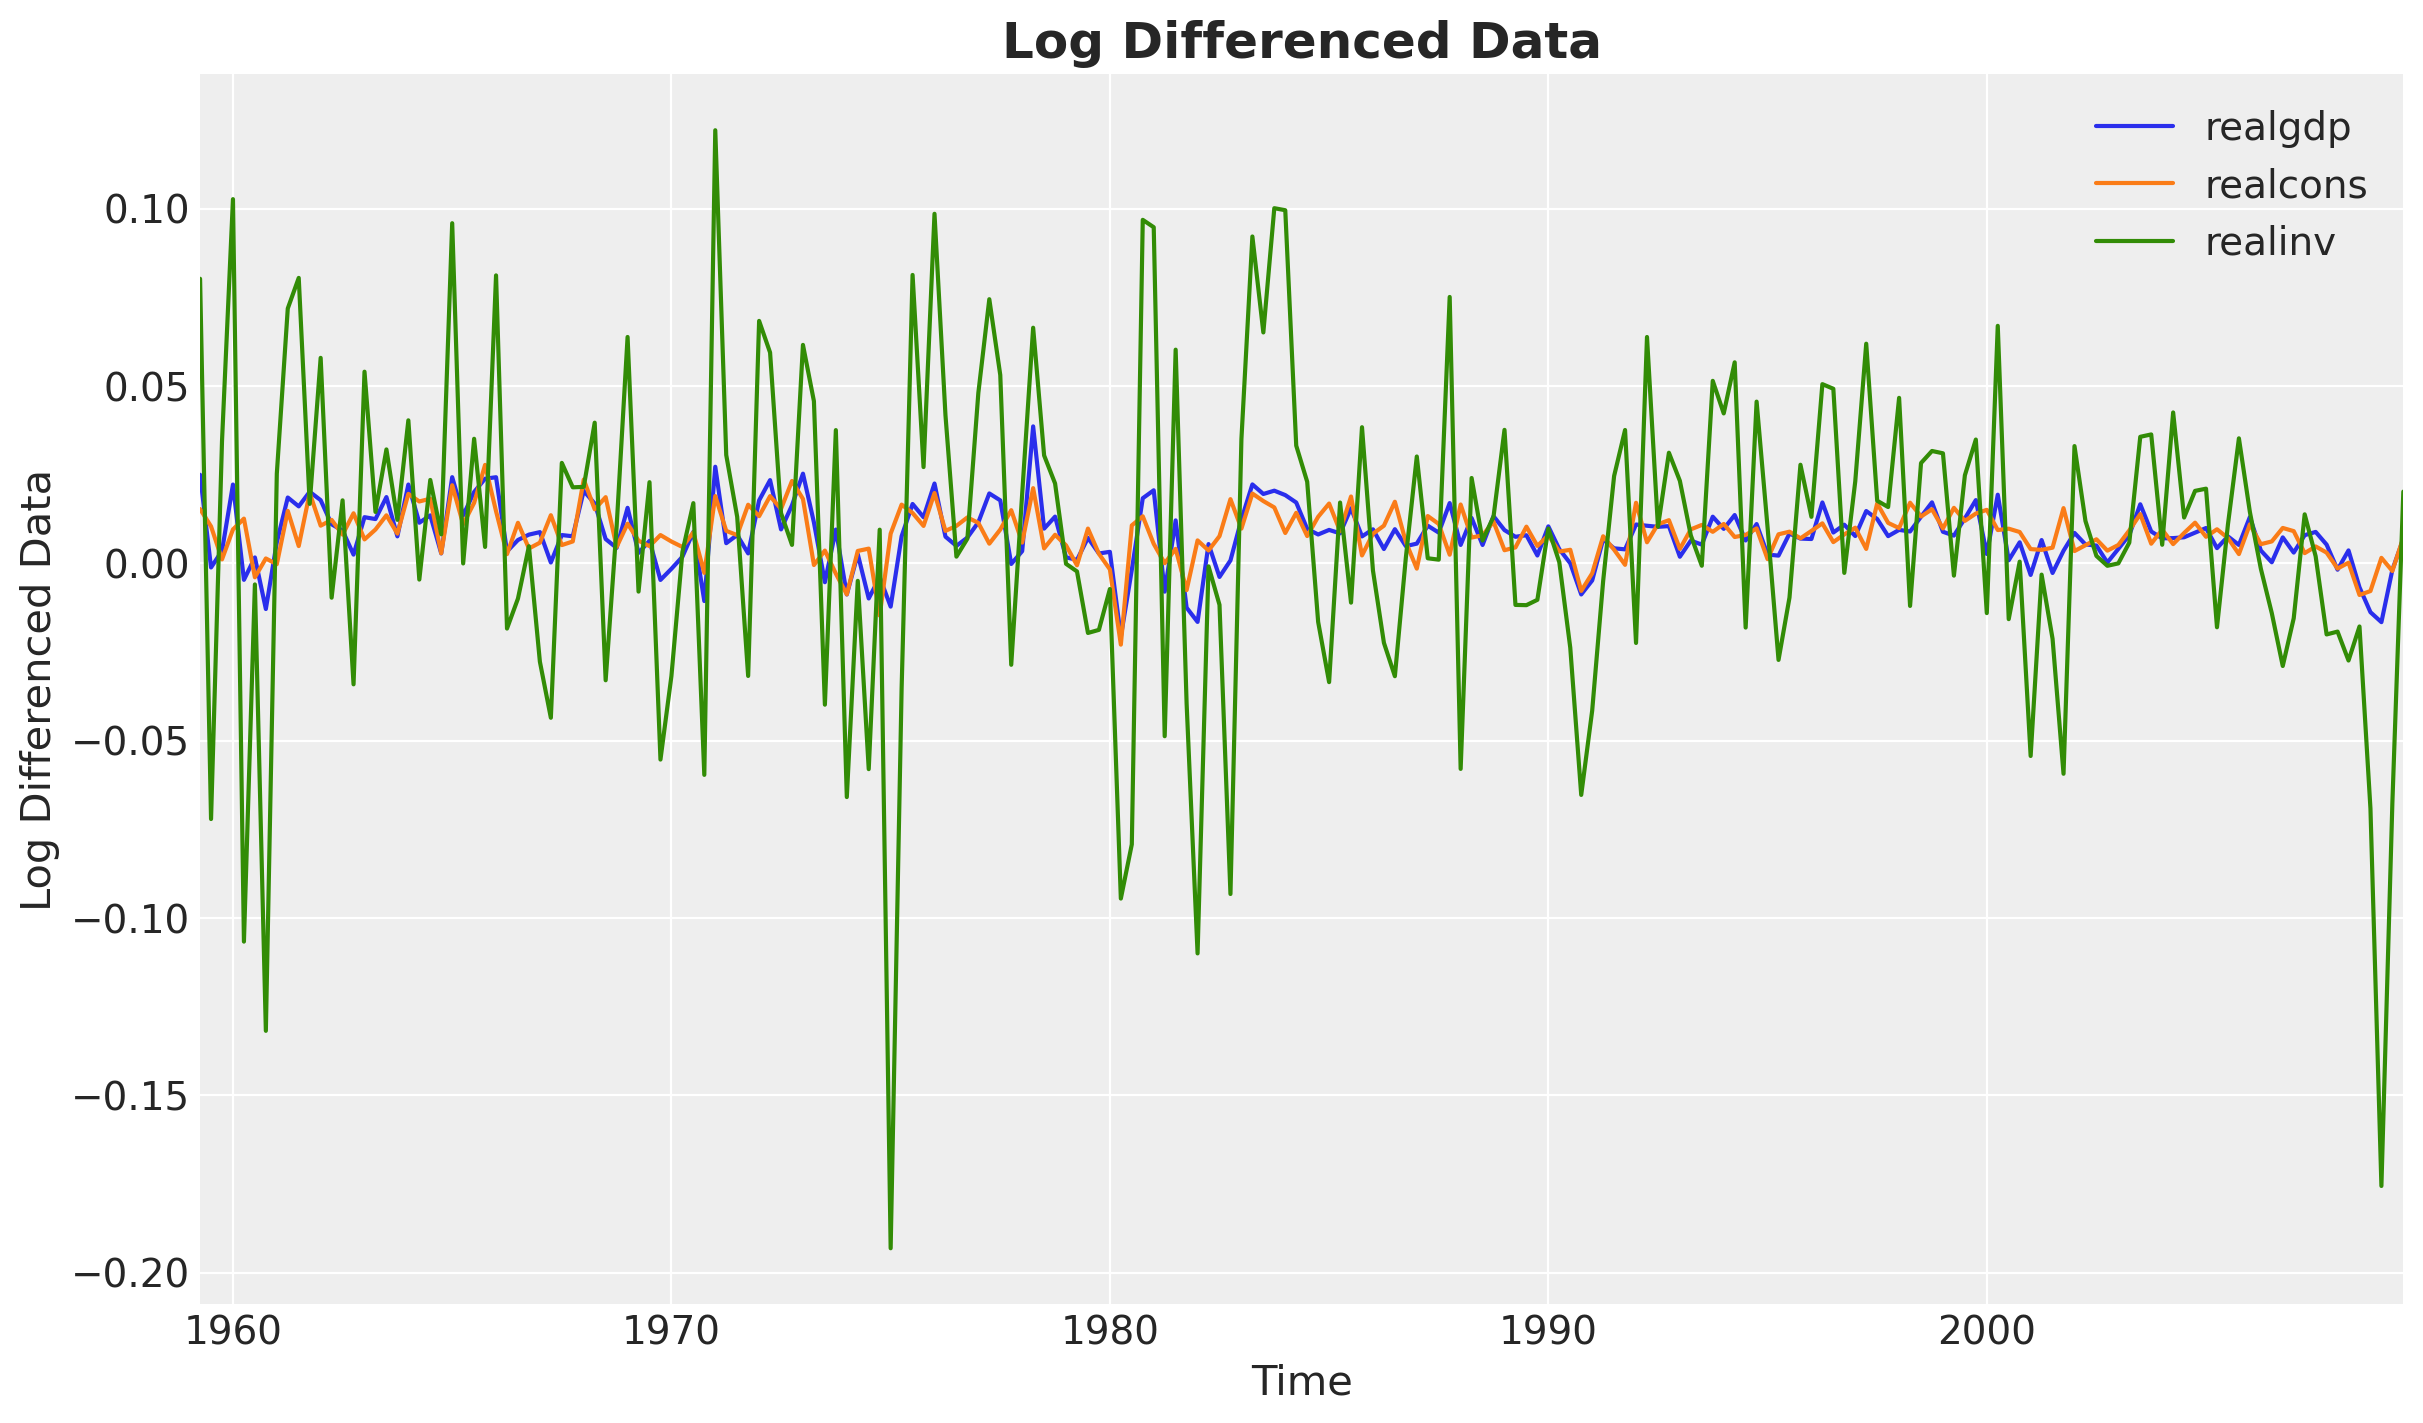

In [55]:
fig, ax = plt.subplots()
data.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Log Differenced Data")
ax.set_title("Log Differenced Data", fontsize=18, fontweight="bold");

It looks like the data is stationary.

## Fit VAR Model with Statsmodels

Recall taht a $\text{VAR}(p)$ model can be written as:

$$
Y_t = c + \sum_{j=1}^{p} \Phi_j Y_{t-j} + \varepsilon_t,
$$

where $c$ is a vector of constants, $\Phi_j$ is the coefficient matrix for the $j$-th lag, and $\varepsilon_t$ is the error term which is a vector of i.i.d. normal random variables with mean $0$ and covariance matrix $\Sigma$ . Each matrix $\Phi_j$ has dimensions $(k, k)$ where $k$ is the number of variables in the model. Let $\Phi = [\Phi_1, \Phi_2, \ldots, \Phi_p]$ be the tensor of coefficient matrices of shape $(p, k, k)$ so that we can write the model in vectorized form as:
$$
Y_t = c + \Phi \times \begin{bmatrix} Y_{t-1} \\ Y_{t-2} \\ \vdots \\ Y_{t-p} \end{bmatrix} + \varepsilon_t,
$$

Before implementing the model in Numpyro, we fit a VAR model using the `statsmodels` package to get the reference values.

In [3]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Oct, 2025
Time:                     14:54:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

## NumPyro Implementation

Next, we implement the model in Numpyro. The core idea is taken from the NumPyro docs: [Example: VAR(2) process](https://num.pyro.ai/en/stable/examples/var2.html). In our implementation, we make it in such a way that we vectorize the computation over the lags components (i.e. this works for lags larger than $2$).

### Vecorization over Lags

The vectorization is a bit tricky at first. So before jumping into the model, we conmsider a simple example. The idea is to vecortize the coeficient matrix $\Phi$ over the lags $j=1, \ldots, p$. Let us consider the case of $p=2$ and generate a syntetic matrix $\Phi$ as we mainly casre about the computation and not the values themselves for now.

In [6]:
# number of variables (taken from the data)
n_vars = data.shape[1]
# number of lags
n_lags = 2

# generate a synthetic matrix
phi = jnp.arange(n_lags * n_vars * n_vars).reshape(n_lags, n_vars, n_vars)

phi

Array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]], dtype=int32)

For the matrix $\Phi$, the first dimension is the lags, the second dimension is the variables on the rows and the third dimension is the variables on the columns that we want to multiply and sum.



Next, we consder a synthetic lags vector which whould represent the lags of the dependent variable $Y_t$.

In [7]:
y_lags = 2 * jnp.ones((n_lags, n_vars))

y_lags

Array([[2., 2., 2.],
       [2., 2., 2.]], dtype=float32)

The tensor operation we want to perform is:

In [8]:
# Element-wise multiplication and sum over the third dimension (columns).
(phi * y_lags[..., jnp.newaxis]).sum(axis=(0, 2))

Array([ 66., 102., 138.], dtype=float32)

This can be achieved by using the [`einsum`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.einsum.html) function with a proper specification of the indices.

In [9]:
jnp.einsum("lij,lj->i", phi, y_lags)

Array([ 66., 102., 138.], dtype=float32)

We will use the einsum function to perform the operation in the NumPyro model.

### NumPyro Model

We are now ready to implement the VAR model in NumPyro. The idea is to use the scan function as in the previous example [Notes on an ARMA(1, 1) Model with NumPyro](https://juanitorduz.github.io/arma_numpyro/), see also the [PyData Amsterdam](https://amsterdam2024.pydata.org/cfp/talk/YBTSUV/) video [Time Series forecasting with NumPyro](https://www.youtube.com/watch?v=9Q6r2w0CDB0) for more details.

In [33]:
def model(
    y: Float[Array, "time vars"], n_lags: int
) -> Float[Array, "time_minus_n_lags vars"]:
    # Get the number of time steps and variables
    n_time, n_vars = y.shape

    # --- Priors ---
    constant = numpyro.sample("constant", dist.Normal(loc=0, scale=1).expand([n_vars]))

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1.0).expand([n_vars]))

    l_omega = numpyro.sample(
        "l_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
    )
    l_sigma = jnp.einsum("...i,...ij->...ij", sigma, l_omega)

    # Sample phi coefficients - shape (n_lags, n_vars, n_vars)
    # The first dimension is the lags, the second dimension is the variables on the rows
    # and the third dimension is the variables on the columns that
    # we want to multiply and sum.
    phi = numpyro.sample(
        "phi", dist.Normal(0, 10).expand([n_lags, n_vars, n_vars]).to_event(3)
    )

    # --- Transition Function ---

    def transition_fn(carry: Array, _) -> tuple[Array, Array]:
        # carry: (n_lags, n_vars)
        y_lags = carry

        # Compute lag contributions as a matrix product of phi and y_lags
        # (see the example above!)
        lag_contributions = jnp.einsum("lij,lj->i", phi, y_lags)
        # Compute VAR mean
        m_t = constant + lag_contributions

        # Sample observation
        y_t = numpyro.sample(
            "y_pred", dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma)
        )

        # Update carry: remove oldest, add newest
        new_carry = jnp.concatenate([y_lags[1:], y_t[None, :]], axis=0)
        return new_carry, y_t

    # Initialize and run scan
    init_carry = y[:n_lags]
    time_indices = jnp.arange(n_lags, n_time)

    with condition(data={"y_pred": y[n_lags:]}):
        _, y_pred = scan(transition_fn, init=init_carry, xs=time_indices)

    return y_pred

Let's visualize the model:

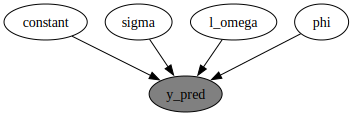

In [34]:
y: Float[Array, "time vars"] = jnp.array(data)

numpyro.render_model(model, model_kwargs={"y": y, "n_lags": 2})

Nothing fancym but at least the mdoel renders 😄.

## Fit Numpyro Model

We now sample from the posterior distribution of the model using MCMC.

In [35]:
%%time

nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1_000,
    num_samples=2_000,
    num_chains=4,
)

# Run inference
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, y=y, n_lags=2)

# Get samples
samples = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 2min 18s, sys: 875 ms, total: 2min 19s
Wall time: 36.1 s


Let's parse the samples to an ArviZ InferenceData object.

**Warning:** From the model specification above, the the first entry in the  initial `carry` vector `init_carry = y[:n_lags]` is the oldest lag and the last entry is the newest lag. This little detail is essential here as we need to invert the lag coordinates to match the statsmodels results.

In [36]:
idata = az.from_numpyro(
    mcmc,
    coords={
        "var_1": data.columns,
        "var_2": data.columns,
        "lag": range(2, 0, -1),
    },
    dims={
        "constant": ["vars"],
        "sigma": ["vars"],
        "l_omega": ["var_1", "var_2"],
        "phi": ["lag", "var_1", "var_2"],
    },
)

We can now visualize the traces.

/Users/juan.orduz/Documents/website_projects/.pixi/envs/default/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


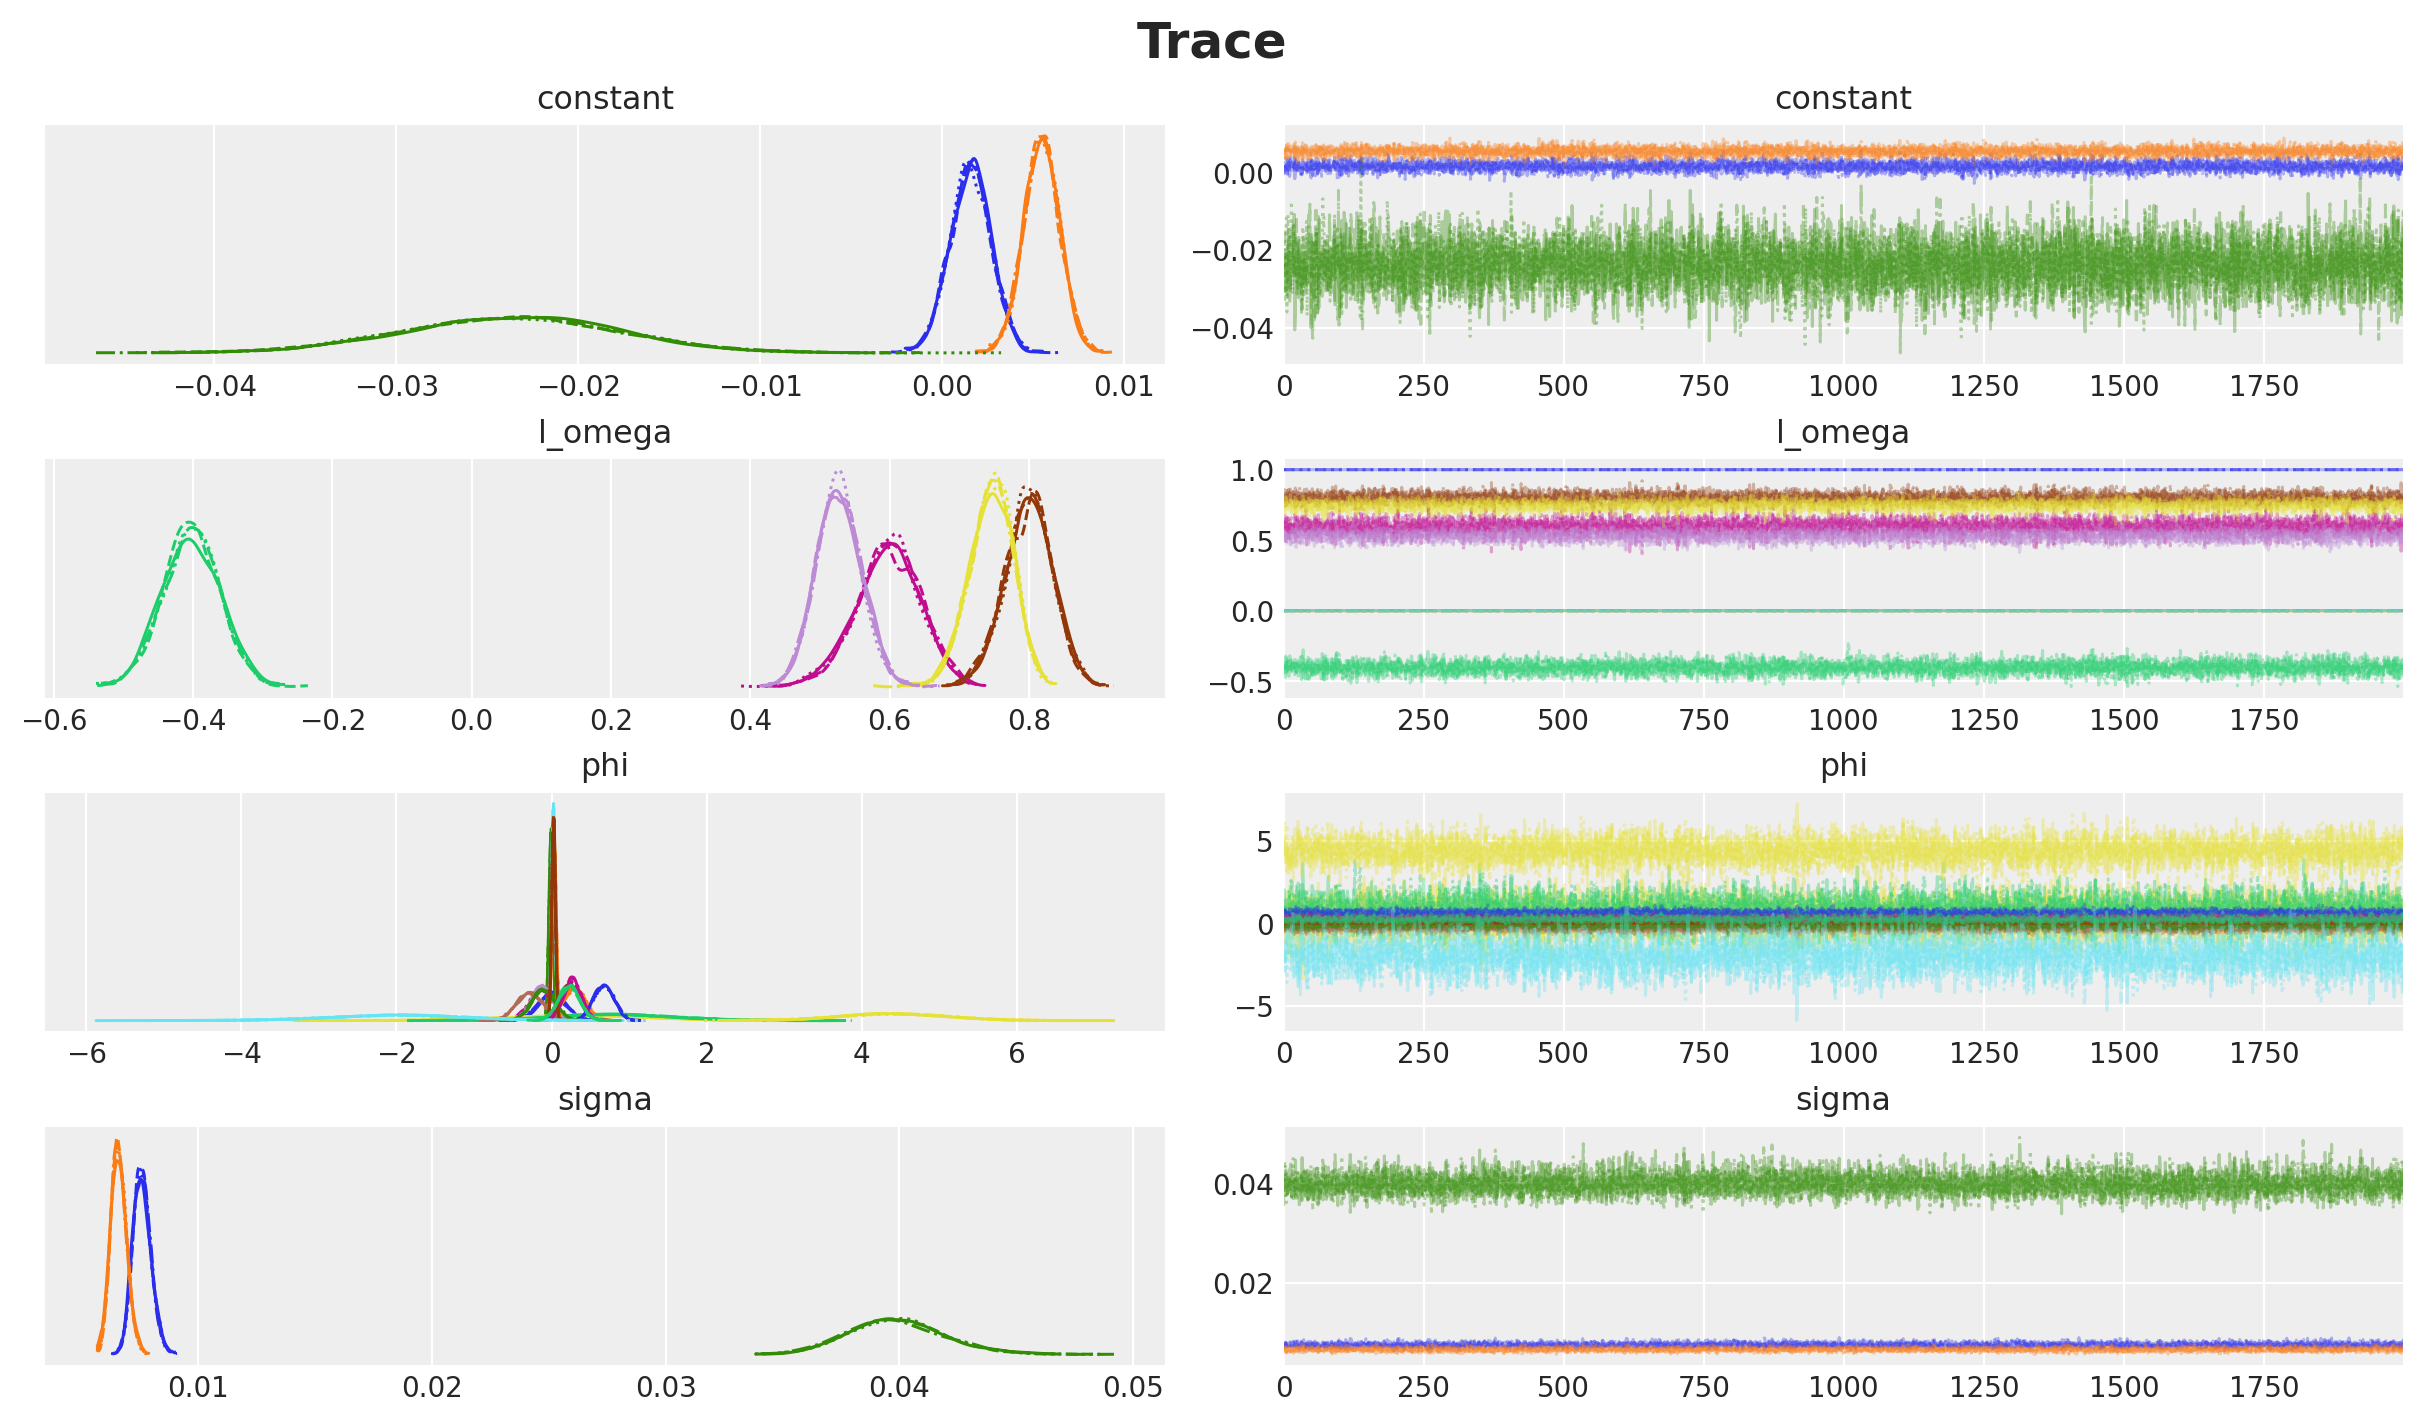

In [40]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=18, fontweight="bold");

Overal, the chains seem to converge well.

## Parameter Comparison

We can manually inspect certain parameters mean values to see if they match the reference values from the `statsmodels` results.

In [ ]:
(
    idata["posterior"]["phi"]
    .mean(dim=["chain", "draw"])
    .sel(var_1="realgdp")
    .to_dataframe()
    .sort_index()
)

var_1       phi
lag var_2                      
1   realcons  realgdp  0.675573
    realgdp   realgdp -0.282918
    realinv   realgdp  0.033723
2   realcons  realgdp  0.292056
    realgdp   realgdp  0.004677
    realinv   realgdp -0.006561

In [61]:
var_results.params["realgdp"].to_frame()

,realgdp
const,0.001527
L1.realgdp,-0.279435
L1.realcons,0.675016
L1.realinv,0.033219
L2.realgdp,0.008221
L2.realcons,0.290458
L2.realinv,-0.007321


We do see the values are very close 🚀! 

Similarly, we can look into the correlation matrix:

In [65]:
l_omega_mean = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"])

corr_mean = l_omega_mean.to_numpy() @ l_omega_mean.to_numpy().T

corr_mean

array([[1.        , 0.5977151 , 0.74590814],
       [0.5977151 , 0.99671996, 0.12397049],
       [0.74590814, 0.12397049, 0.9962846 ]], dtype=float32)

Which is very close to the correlation matrix from the `statsmodels` summary results above.

Finally, we can compare all the $\Phi$ parameters with the estimated posterior distributions.

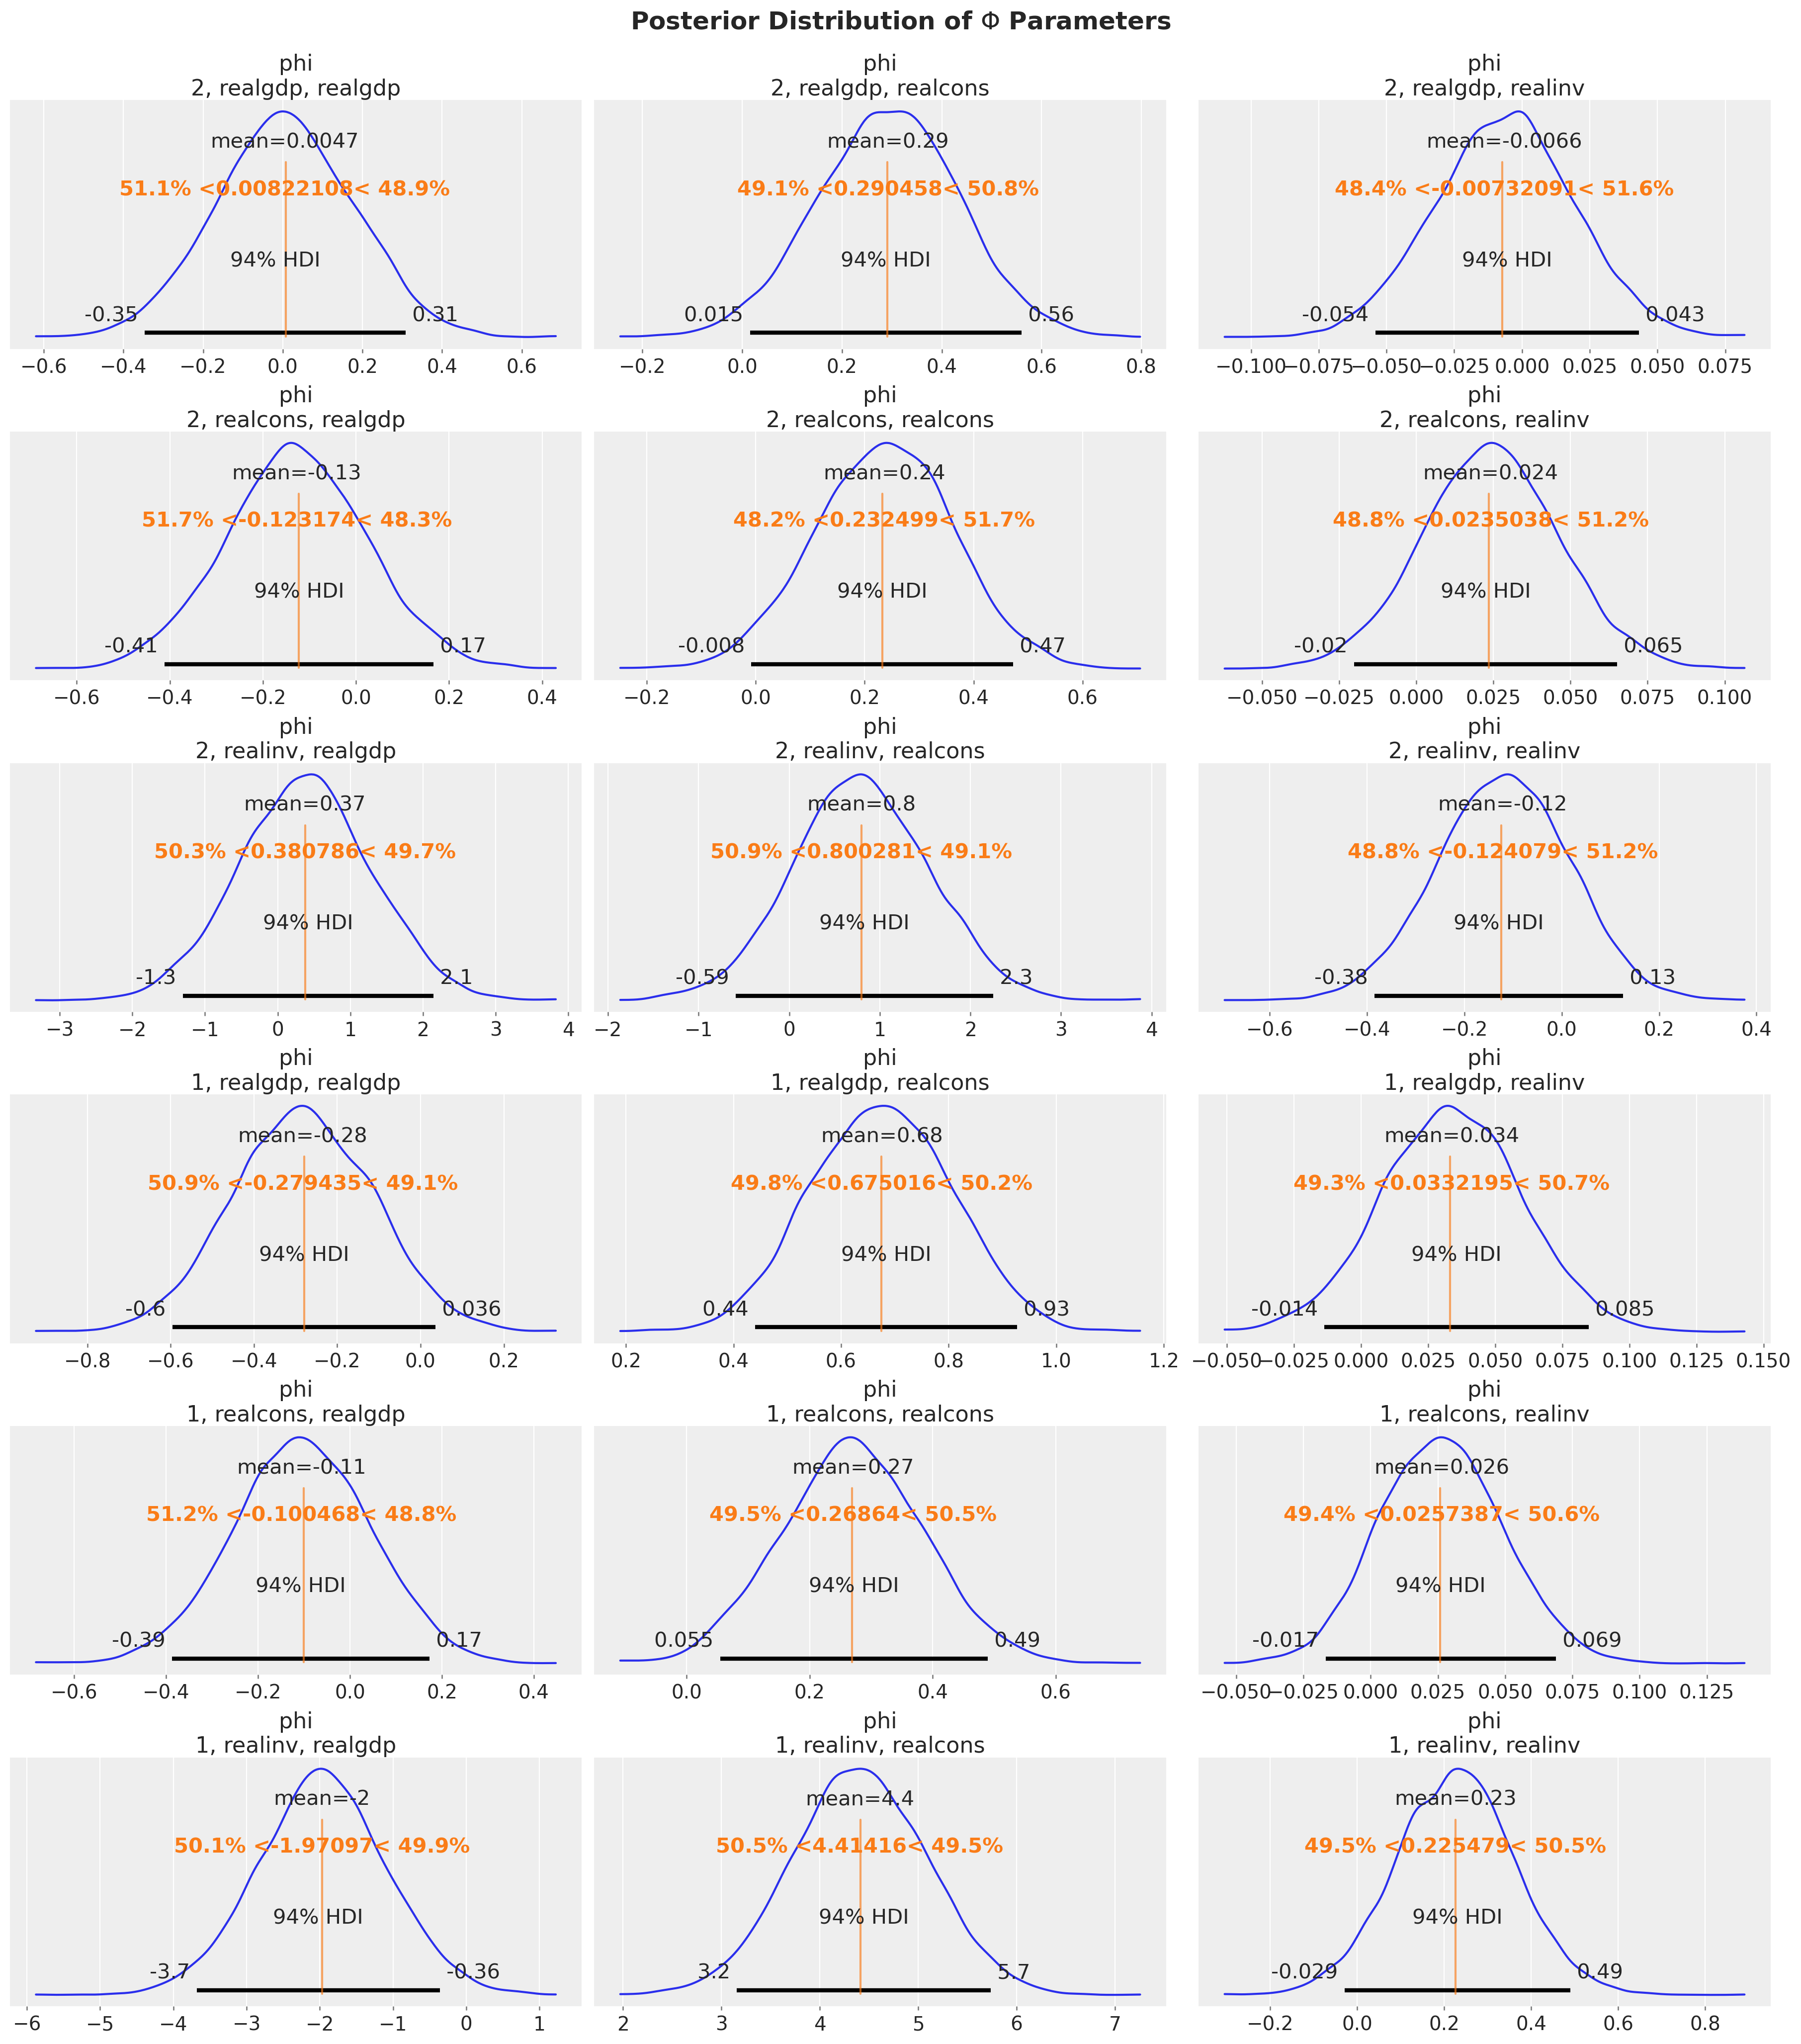

In [81]:
# Reference values from statsmodels VAR(2) results
# Simplified construction using list comprehension and f-strings
lags = range(2, 0, -1)
variables = data.columns

ref_vals_phi = {
    "phi": [
        {
            "lag": lag,
            "var_1": var_1,
            "var_2": var_2,
            "ref_val": var_results.params[var_1][f"L{lag}.{var_2}"],
        }
        for lag in lags
        for var_1 in variables
        for var_2 in variables
    ]
}

axes = az.plot_posterior(
    idata,
    var_names=["phi"],
    ref_val=ref_vals_phi,
    figsize=(18, 20),
)
fig = axes[0][0].figure
fig.suptitle(
    r"Posterior Distribution of $\Phi$ Parameters",
    fontsize=18,
    fontweight="bold",
    y=1.02,
);

All of the estimated parameters are very close to the reference values!

## Impulse Response Functions (IRFs)?

After fitting a VAR model, we often want to understand **how the system responds to shocks**. This is where Impulse Response Functions (IRFs) come in.

### The Intuition

Imagine you have three economic variables: GDP, consumption, and investment. Now suppose there's an unexpected shock to GDP (e.g., a sudden policy change). An IRF answers questions like:
- How does GDP itself respond over time?
- How does consumption react to this GDP shock?
- What happens to investment in subsequent periods?

IRFs trace out the **dynamic response** of each variable to a one-time shock in another variable, holding all else constant.

### From VAR to MA Representation

Recall our $\text{VAR}(p)$ model:

$$Y_t = c + \sum_{j=1}^{p} \Phi_j Y_{t-j} + \varepsilon_t$$

This model tells us how current values depend on past values. But to compute IRFs, we need the **Moving Average (MA) representation**, which expresses current values in terms of current and past shocks:

$$Y_t = \mu + \sum_{i=0}^{\infty} \Psi_i \varepsilon_{t-i}$$

where:
- $\Psi_0 = I$ (identity matrix - a shock has immediate unit effect on itself)
- $\Psi_i$ are the **MA coefficient matrices** that tell us the response at time $i$ to a shock at time 0
- These $\Psi_i$ matrices **are** the IRFs!

### The Recursive Algorithm

The beautiful part is that we can compute the $\Psi_i$ matrices recursively from the VAR coefficients $\Phi_j$:

$$\Psi_0 = I$$

$$\Psi_i = \sum_{j=1}^{\min(i, p)} \Psi_{i-j} \Phi_j \quad \text{for } i \geq 1$$

This means:
- At time 0: The response is just the identity (shock = response)
- At time 1: $\Psi_1 = \Psi_0 \Phi_1 = \Phi_1$ (first-order effects)
- At time 2: $\Psi_2 = \Psi_1 \Phi_1 + \Psi_0 \Phi_2$ (effects compound!)
- And so on...

Each $\Psi_i[k, j]$ tells us: **"What is the response of variable k at time i to a unit shock in variable j at time 0?"**

### Implementation Strategy

The `compute_irf` function below implements this recursive algorithm efficiently using:
1. **JAX's `lax.scan`** for fast, functional iteration
2. **JIT compilation** for maximum speed
3. **Vectorization** to compute all responses simultaneously

This allows us to:
- Compute IRFs from our Bayesian VAR posterior samples
- Get uncertainty bands around the impulse responses
- Compare with statsmodels results
- Scale to larger models and longer time horizons

Let's see how it works! 👇


## Impulse Response Functions

In [ ]:
def compute_irf(
    phi: Float[Array, "n_lags n_vars n_vars"],
    n_steps: int,
    shock_size: float = 1.0,
) -> Float[Array, "n_steps n_vars n_vars"]:
    """
    Compute MA(∞) representation of VAR(p) process (non-orthogonalized IRF).

    Implements the statsmodels ma_rep algorithm using jax.lax.scan:
    Phi_0 = I
    Phi_i = sum_{j=1}^{min(i,p)} Phi_{i-j} @ A_j for i >= 1

    Parameters
    ----------
    phi : array of shape (n_lags, n_vars, n_vars)
        VAR coefficient matrices. phi[j-1] corresponds to A_j.
        IMPORTANT: phi[0] must be lag 1 coefficients, phi[1] must be lag 2, etc.
        If your coords are reversed (e.g., range(2, 0, -1)), you must reverse
        the array before passing it to this function: phi = phi[::-1]
    n_steps : int
        Number of MA coefficient matrices to compute.
    shock_size : float, default=1.0
        Scaling factor for identity matrix at t=0.

    Returns
    -------
    phis : array of shape (n_steps, n_vars, n_vars)
        MA representation. phis[i, :, j] is response of all variables
        at time i to a unit shock to variable j at time 0.
    """
    from jax import lax

    n_lags, n_vars, _ = phi.shape

    def scan_fn(carry, i):
        """
        Compute Phi_i from previous MA matrices.

        carry: Array of shape (n_lags, n_vars, n_vars) containing the last n_lags MA matrices
               carry[0] is Phi_{i-1}, carry[1] is Phi_{i-2}, ..., carry[n_lags-1] is Phi_{i-n_lags}
        i: current time step
        """
        # Compute Phi_i = sum_{j=1}^{min(i,p)} Phi_{i-j} @ A_j
        # We need to handle the case where i < n_lags (early steps)

        # carry[0] is Phi_{i-1}, carry[1] is Phi_{i-2}, etc.
        # phi[0] is A_1 (lag 1), phi[1] is A_2 (lag 2), etc.

        # For each lag j from 1 to min(i, n_lags):
        #   Phi_{i-j} is carry[j-1]
        #   A_j is phi[j-1]

        # Create a mask to only sum over valid lags (up to min(i, n_lags))
        valid_lags = jnp.arange(n_lags) < jnp.minimum(i, n_lags)

        # Compute contributions: Phi_{i-j} @ A_j for each j
        # carry[j] @ phi[j] for j in range(n_lags)
        contributions = jnp.einsum("jkl,jlm->jkm", carry, phi)

        # Mask invalid contributions and sum
        phi_i = jnp.sum(contributions * valid_lags[:, None, None], axis=0)

        # Update carry: shift everything by 1 and add new phi_i at the front
        new_carry = jnp.concatenate([phi_i[None, :, :], carry[:-1]], axis=0)

        return new_carry, phi_i

    # Initialize carry with zeros and set Phi_0 = I at the front
    phi_0 = shock_size * jnp.eye(n_vars)
    init_carry = jnp.concatenate(
        [phi_0[None, :, :], jnp.zeros((n_lags - 1, n_vars, n_vars))], axis=0
    )

    # Run scan for steps 1 to n_steps-1
    if n_steps == 1:
        return phi_0[None, :, :]

    time_steps = jnp.arange(1, n_steps)
    _, phis_rest = lax.scan(scan_fn, init_carry, time_steps)

    # Concatenate Phi_0 with the rest
    phis = jnp.concatenate([phi_0[None, :, :], phis_rest], axis=0)

    return phis

In [ ]:
# Verify that the new scan-based implementation matches statsmodels
# Using the exact statsmodels coefficients
phi_sm = jnp.array(var_results.coefs)
n_test_steps = 10

# Compute IRF with scan-based function
irf_jax_scan = compute_irf(phi_sm, n_steps=n_test_steps)

# Get statsmodels IRF (ma_rep)
irf_sm = var_results.ma_rep(maxn=n_test_steps - 1)

# Compare
max_diff = jnp.max(jnp.abs(irf_jax_scan - irf_sm))
print(f"Maximum absolute difference between JAX (scan) and statsmodels: {max_diff:.2e}")

if max_diff < 1e-6:
    print("✓ Scan-based implementation matches statsmodels perfectly!")
else:
    print("✗ Differences detected")
    print(f"\nIRF at t=0 difference:\n{jnp.abs(irf_jax_scan[0] - irf_sm[0])}")
    print(f"\nIRF at t=1 difference:\n{jnp.abs(irf_jax_scan[1] - irf_sm[1])}")

In [ ]:
# Benchmark: Compare JIT-compiled vs non-JIT performance
import time

from jax import jit

# JIT-compile the function
# Note: n_steps is a static argument (compile-time constant)
compute_irf_jit = jit(compute_irf, static_argnames=["n_steps"])

# Warm-up: First call includes compilation time
print("Warming up JIT compilation...")
_ = compute_irf_jit(phi_sm, n_steps=10)
print("✓ JIT compilation complete!\n")

# Benchmark with a larger number of steps
n_benchmark_steps = 50
n_runs = 100

# Non-JIT version
print("Benchmarking non-JIT version...")
start = time.time()
for _ in range(n_runs):
    _ = compute_irf(phi_sm, n_steps=n_benchmark_steps)
time_no_jit = (time.time() - start) / n_runs

# JIT version
print("Benchmarking JIT version...")
start = time.time()
for _ in range(n_runs):
    _ = compute_irf_jit(phi_sm, n_steps=n_benchmark_steps)
    _.block_until_ready()  # Wait for GPU/TPU computation to finish
time_jit = (time.time() - start) / n_runs

# Results
print(f"\n{'=' * 60}")
print(f"PERFORMANCE COMPARISON ({n_benchmark_steps} IRF steps)")
print(f"{'=' * 60}")
print(f"Non-JIT version: {time_no_jit * 1000:.3f} ms per call")
print(f"JIT version:     {time_jit * 1000:.3f} ms per call")
print(f"Speedup:         {time_no_jit / time_jit:.1f}x faster with JIT")
print("\n✓ Use compute_irf_jit for production code!")

print("\n" + "=" * 60)
print("ADVANTAGES OF SCAN + JIT:")
print("=" * 60)
print("  1. Significant speedup (typically 10-50x faster)")
print("  2. Memory efficient (no intermediate array storage)")
print("  3. Better for automatic differentiation if needed")
print("  4. Can be vmapped over multiple posterior samples")
print("  5. Idiomatic JAX code")

In [ ]:
# Advanced: Compute IRFs for ALL posterior samples using vmap
# This is useful for uncertainty quantification
from jax import vmap

# Get all posterior samples (flatten chain and draw dimensions)
phi_samples = idata["posterior"]["phi"].stack(sample=["chain", "draw"]).values
# Reverse lag order for all samples
phi_samples = phi_samples[::-1, :, :, :]  # Shape: (n_lags, n_vars, n_vars, n_samples)

# Transpose to get samples as first dimension
phi_samples = jnp.transpose(
    phi_samples, (3, 0, 1, 2)
)  # Shape: (n_samples, n_lags, n_vars, n_vars)

print(f"Phi samples shape: {phi_samples.shape}")
print(f"Number of posterior samples: {phi_samples.shape[0]}")

# Create a vmapped version that computes IRF for each posterior sample
# vmap over the first axis (samples)
compute_irf_vmap = vmap(compute_irf_jit, in_axes=(0, None, None))

# Compute IRFs for all samples at once!
print(f"\nComputing IRFs for all {phi_samples.shape[0]} posterior samples...")
n_irf_steps = 10
irf_samples = compute_irf_vmap(phi_samples, n_irf_steps, 1.0)

print(f"IRF samples shape: {irf_samples.shape}")
print(
    f"Shape: (n_samples={irf_samples.shape[0]}, n_steps={irf_samples.shape[1]}, n_vars={irf_samples.shape[2]}, n_vars={irf_samples.shape[3]})"
)

# Compute credible intervals
irf_mean_vmap = irf_samples.mean(axis=0)
irf_lower = jnp.percentile(irf_samples, 5, axis=0)
irf_upper = jnp.percentile(irf_samples, 95, axis=0)

print("\n✓ Successfully computed IRFs with uncertainty bands!")
print("\nYou can now plot IRFs with credible intervals:")
print("  - irf_mean_vmap: posterior mean IRF")
print("  - irf_lower: 5th percentile")
print("  - irf_upper: 95th percentile")

In [ ]:
# Test IRF computation with posterior mean
phi_mean = idata["posterior"]["phi"].mean(dim=["chain", "draw"]).values
l_omega_mean = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"]).values
sigma_mean = idata["posterior"]["sigma"].mean(dim=["chain", "draw"]).values

# IMPORTANT: Reverse lag order! The coords were defined as range(2, 0, -1) which is [2, 1]
# So phi_mean[0] is lag 2 and phi_mean[1] is lag 1, but compute_irf expects
# phi[0] = lag 1, phi[1] = lag 2
phi_mean = phi_mean[::-1]  # Reverse the lag dimension

# Construct the Cholesky factor
l_sigma_mean = sigma_mean[:, None] * l_omega_mean

# Compute IRF for 10 steps
n_irf_steps = 10
irf_mean = compute_irf(phi_mean, n_steps=n_irf_steps)

print(f"IRF shape: {irf_mean.shape}")
print(f"IRF at t=0 (initial shock):\n{irf_mean[0]}")
print(f"\nIRF at t=1:\n{irf_mean[1]}")

In [ ]:
# Compare with statsmodels IRF
var_irf = var_results.irf(n_irf_steps)

# Plot comparison for a specific shock -> response pair
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

shock_var = "realgdp"
response_vars = ["realgdp", "realcons", "realinv"]
shock_idx = list(data.columns).index(shock_var)

for i, response_var in enumerate(response_vars):
    response_idx = list(data.columns).index(response_var)

    # Statsmodels IRF
    sm_irf = var_irf.irfs[:, response_idx, shock_idx]

    # Our JAX IRF (posterior mean)
    jax_irf = irf_mean[:, response_idx, shock_idx]

    axes[i].plot(sm_irf, label="Statsmodels", marker="o", alpha=0.7)
    axes[i].plot(jax_irf, label="JAX (posterior mean)", marker="s", alpha=0.7)
    axes[i].axhline(0, color="black", linestyle="--", linewidth=0.5)
    axes[i].set_title(f"Response of {response_var} to {shock_var} shock")
    axes[i].set_xlabel("Periods")
    axes[i].set_ylabel("Response")
    axes[i].legend()

plt.tight_layout()
plt.show()